In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
def make_synthetic_dataset(n_features=50, n_informative=10, n_redundant=15, n_samples=10000):
    from sklearn.datasets import make_classification
    # n_informative features, followed by n_redundant, followed by n_repeated duplicates
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,\
                               n_redundant=n_redundant, shuffle=False, random_state=1711)
    cols = []
    n_noise = n_features - n_informative - n_redundant
    for i in range(n_informative):
        cols.append("I" + str(i))
    for i in range(n_redundant):
        cols.append("R" + str(i))
    for i in range(n_noise):
        cols.append("N" + str(i))

    X_df = pd.DataFrame(data=X, columns=cols)
    Y_series = pd.Series(y)
    
    return X_df, Y_series

In [3]:
X, y = make_synthetic_dataset()

#### Plot features with PCA explained variance

In [42]:
def run_pca(df):
    pca = PCA() # Plotting the explained variance and look for the drastic decrease
    df_normalized = (df - df.mean()) / df.std()
    pca.fit(df_normalized)
    
    pca_cols = ['PCA' + str(i) for i in range(df.shape[1])]
    pca_col_variance = list(zip(pca_cols, pca.explained_variance_))
    pca_col_variance.sort(key=lambda x: (x[1], x[0]))
    pca_cols, pca_variances = list(zip(*pca_col_variance))

    return pca_cols, pca_variances

In [43]:
pca_cols, pca_variances = run_pca(X)

<BarContainer object of 50 artists>

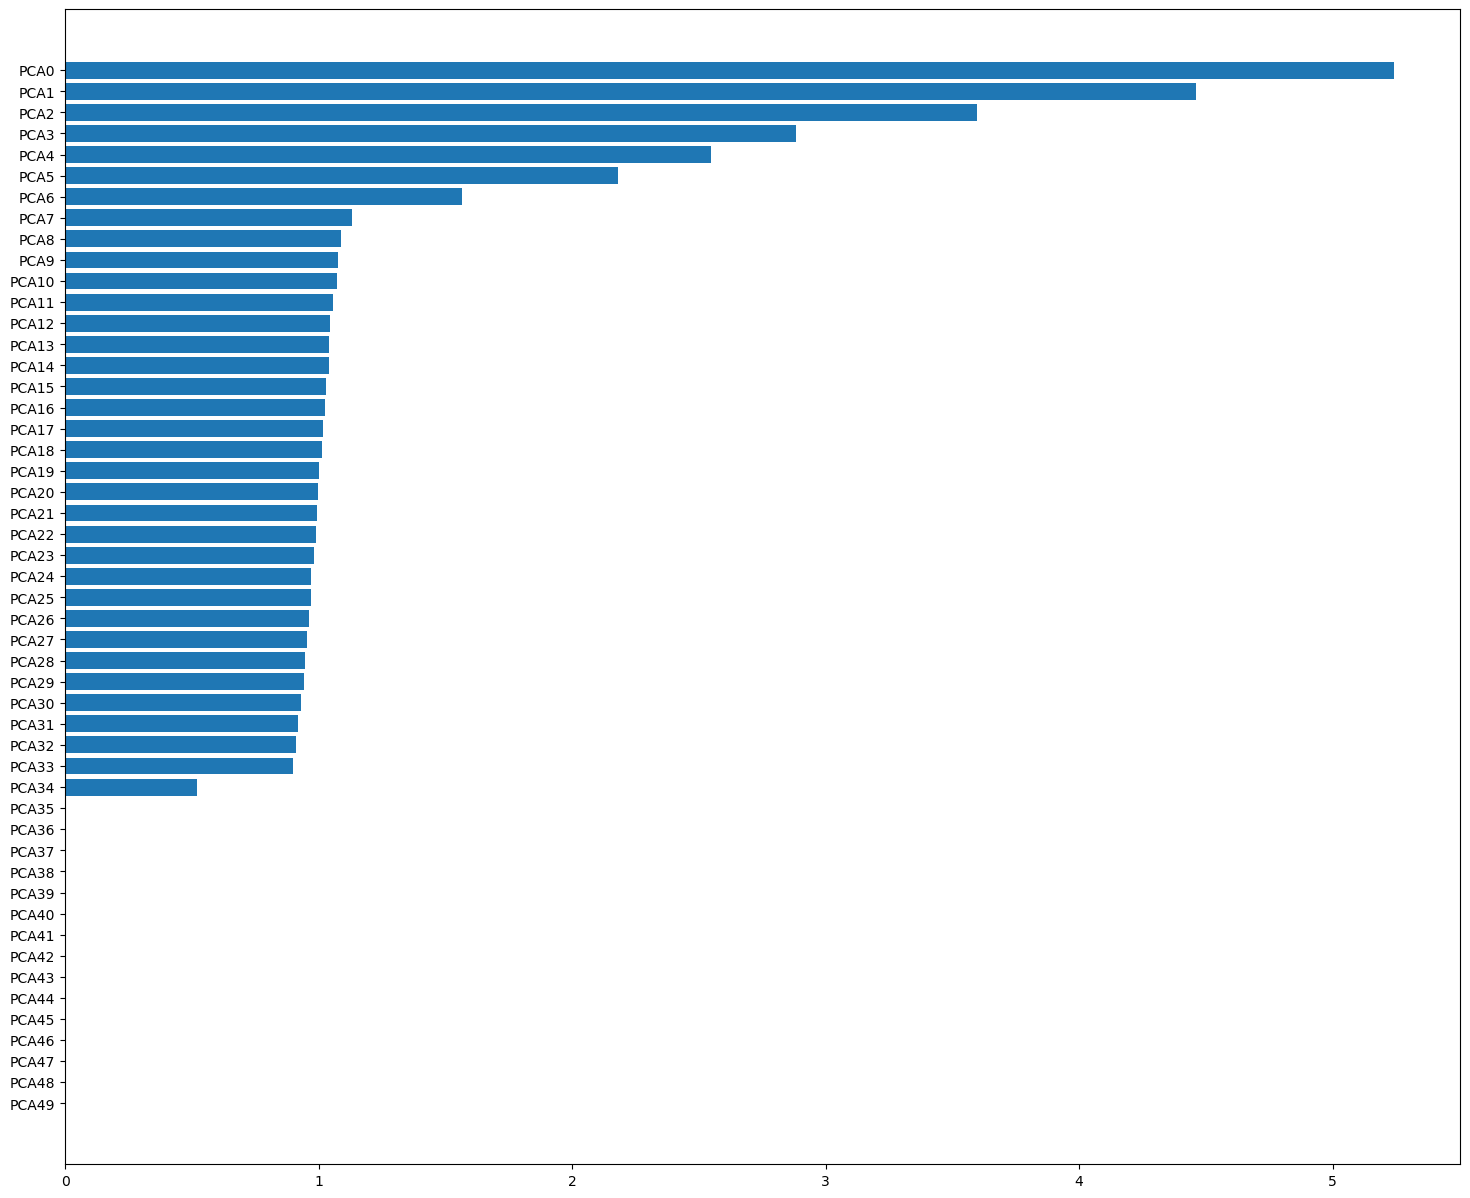

In [44]:
fig, ax = plt.subplots(figsize=(18, 15))
ax.barh(pca_cols, pca_variances)

#### Plot features with MDI on RF

In [8]:
def run_mdi(X, y, rf):
    rf.fit(X, y)
    rf_mdi_feature_scores = list(zip(rf.feature_names_in_, rf.feature_importances_))
    rf_mdi_feature_scores.sort(key=lambda x: (x[1], x[0]))
    rf_features, rf_mdi = list(zip(*rf_mdi_feature_scores))

    return rf_features, rf_mdi

In [9]:
rf = RandomForestClassifier(random_state=1711)
rf_features, rf_mdi = run_mdi(X, y, rf)

<BarContainer object of 50 artists>

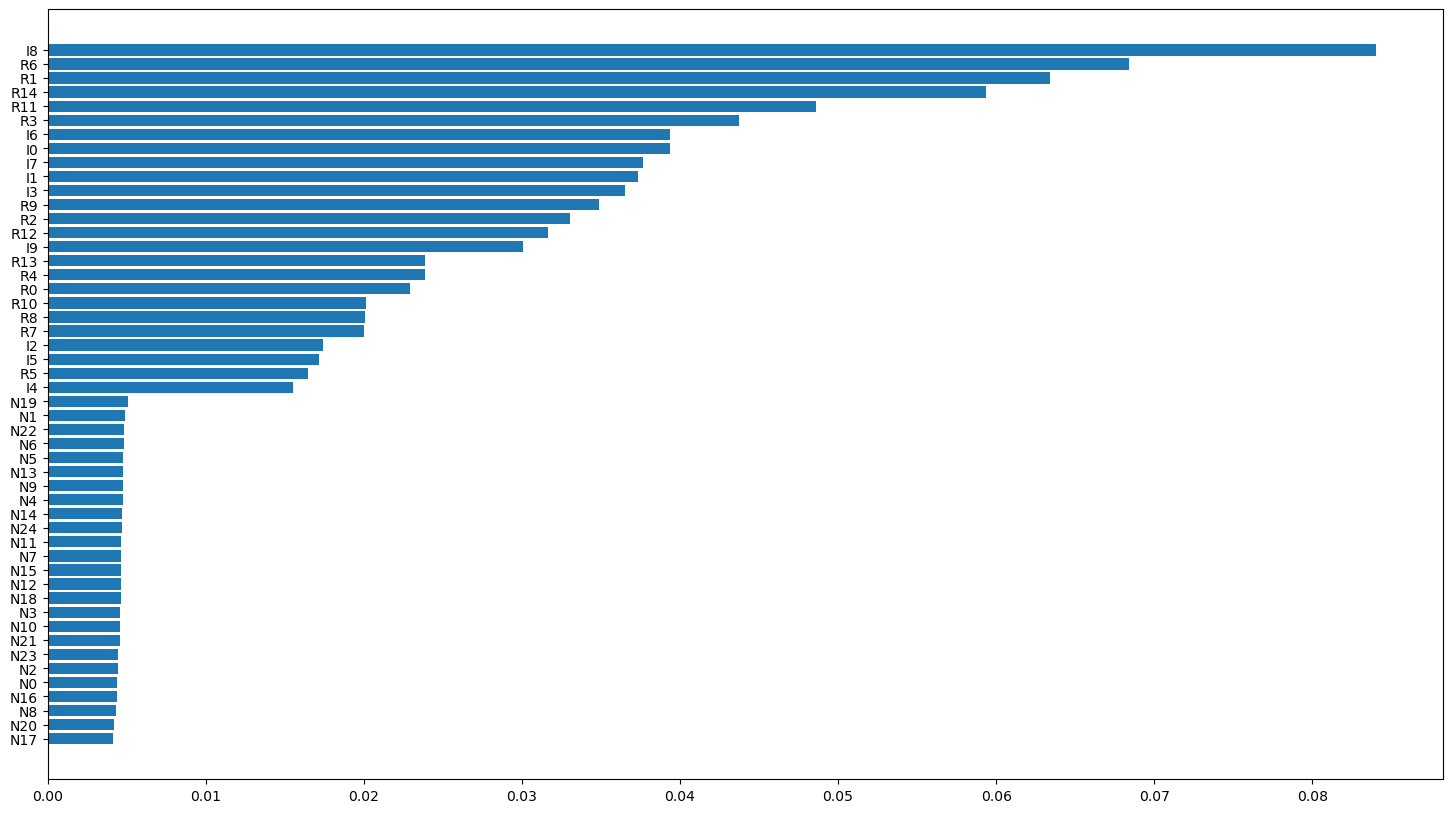

In [10]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.barh(rf_features, rf_mdi)

#### Plot features with MDA using RF

In [11]:
def run_mda(X, y, clf, cv_folds=5):
    clf = clone(clf)
    baseline_accuracy = np.mean(cross_val_score(clf, X, y, cv=cv_folds, n_jobs=-1))
    print("Baseline Accurarcy = {:.4f}".format(baseline_accuracy))

    mda_score_list = []
    for feature in X.columns:
        clf = clone(clf)
        X_shuffle = X.copy()
        X_shuffle[feature] = np.random.permutation(X_shuffle[feature])
        accuracy = np.mean(cross_val_score(clf, X_shuffle, y, cv=cv_folds, n_jobs=-1))
        accuracy_diff = baseline_accuracy - accuracy
        mda_score_list.append((feature, accuracy_diff))
        print("Traing with shuffling feature {}, with accuracy={:.4f} and difference={:.4f}".format(feature, accuracy, accuracy_diff))

    mda_score_list.sort(key=lambda x: (x[1], x[0]), reverse=True)
    mda_features, mda_scores = list(zip(*mda_score_list))

    return mda_features, mda_scores

In [12]:
rf = RandomForestClassifier(random_state=1711)
mda_features, mda_scores = run_mda(X, y, rf)

Baseline Accurarcy = 0.9243
Traing with shuffling feature I0, with accuracy=0.9232 and difference=0.0011
Traing with shuffling feature I1, with accuracy=0.9225 and difference=0.0018
Traing with shuffling feature I2, with accuracy=0.9221 and difference=0.0022
Traing with shuffling feature I3, with accuracy=0.9219 and difference=0.0024
Traing with shuffling feature I4, with accuracy=0.9233 and difference=0.0010
Traing with shuffling feature I5, with accuracy=0.9227 and difference=0.0016
Traing with shuffling feature I6, with accuracy=0.9184 and difference=0.0059
Traing with shuffling feature I7, with accuracy=0.9208 and difference=0.0035
Traing with shuffling feature I8, with accuracy=0.9271 and difference=-0.0028
Traing with shuffling feature I9, with accuracy=0.9237 and difference=0.0006
Traing with shuffling feature R0, with accuracy=0.9241 and difference=0.0002
Traing with shuffling feature R1, with accuracy=0.9229 and difference=0.0014
Traing with shuffling feature R2, with accuracy

<BarContainer object of 50 artists>

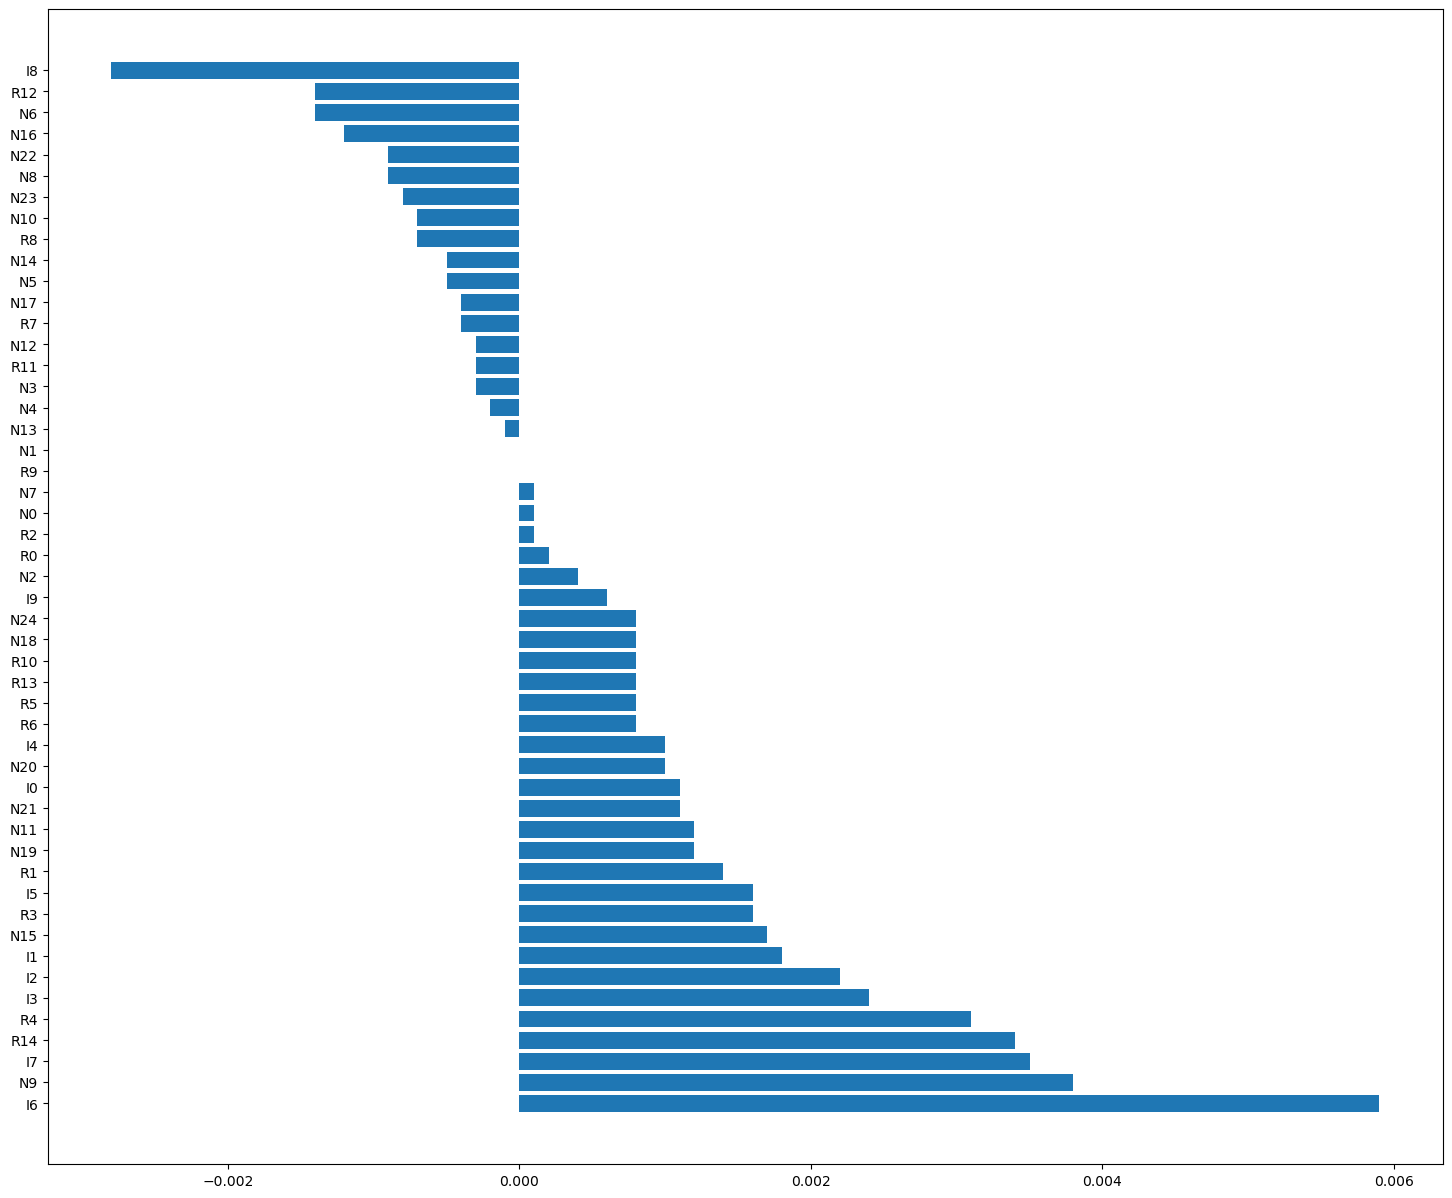

In [13]:
fig, ax = plt.subplots(figsize=(18, 15))
ax.barh(mda_features, mda_scores)

#### Plot features with SFI using RF

In [22]:
def run_sfi(X, y, clf, cv_folds=5):
    clf = clone(clf)
    baseline_accuracy = np.mean(cross_val_score(clf, X, y, cv=cv_folds, n_jobs=-1))
    print("Baseline Accurarcy = {:.4f}".format(baseline_accuracy))
    
    sfi_score_list = []
    for feature in X.columns:
        clf = clone(clf)
        accuracy = np.mean(cross_val_score(clf, X[[feature]], y, cv=cv_folds, n_jobs=-1))
        accuracy_diff = baseline_accuracy - accuracy
        sfi_score_list.append((feature, accuracy_diff))
        print("Traing RF on the single feature {}, with accuracy={:.4f} and difference={:.4f}".format(feature, accuracy, accuracy_diff))

    sfi_score_list.sort(key=lambda x: (x[1], x[0]), reverse=True)
    sfi_features, sfi_scores = list(zip(*sfi_score_list))

    return sfi_features, sfi_scores

In [23]:
rf = RandomForestClassifier(random_state=1711)
sfi_features, sfi_scores = run_sfi(X, y, rf)

Baseline Accurarcy = 0.9243
Traing RF on the single feature I0, with accuracy=0.5522 and difference=0.3721
Traing RF on the single feature I1, with accuracy=0.5550 and difference=0.3693
Traing RF on the single feature I2, with accuracy=0.4978 and difference=0.4265
Traing RF on the single feature I3, with accuracy=0.5373 and difference=0.3870
Traing RF on the single feature I4, with accuracy=0.4926 and difference=0.4317
Traing RF on the single feature I5, with accuracy=0.4952 and difference=0.4291
Traing RF on the single feature I6, with accuracy=0.5431 and difference=0.3812
Traing RF on the single feature I7, with accuracy=0.5298 and difference=0.3945
Traing RF on the single feature I8, with accuracy=0.6180 and difference=0.3063
Traing RF on the single feature I9, with accuracy=0.5373 and difference=0.3870
Traing RF on the single feature R0, with accuracy=0.4997 and difference=0.4246
Traing RF on the single feature R1, with accuracy=0.5856 and difference=0.3387
Traing RF on the single 

<BarContainer object of 50 artists>

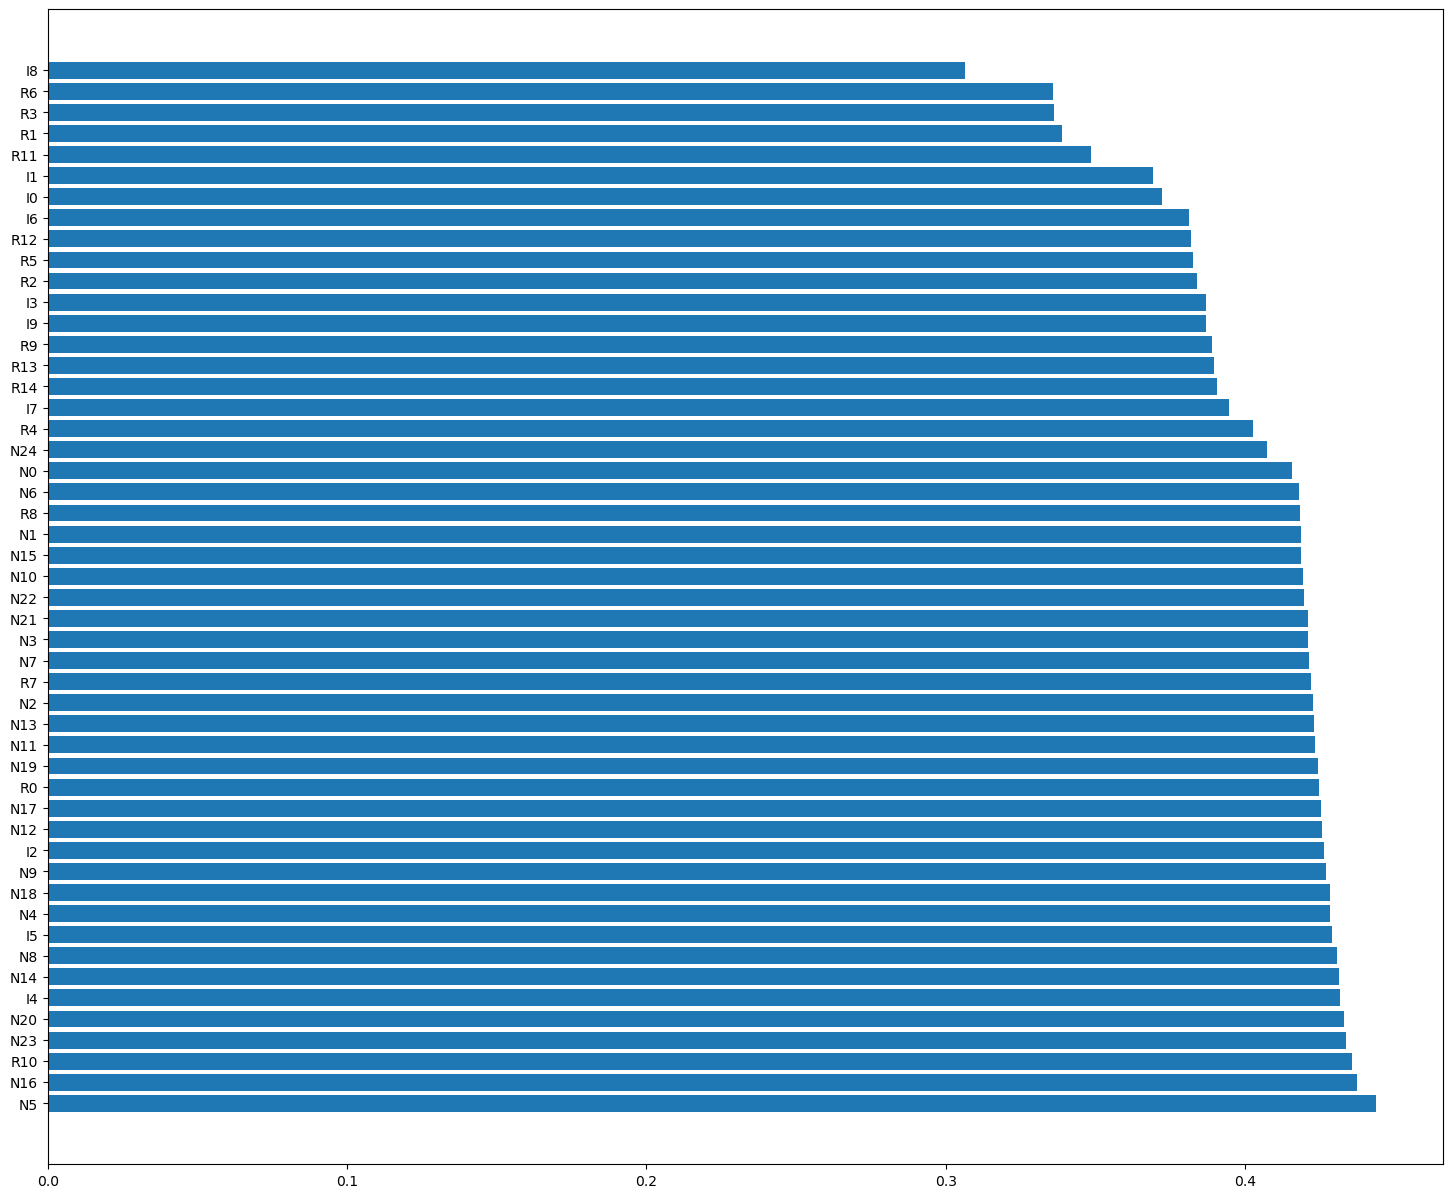

In [24]:
fig, ax = plt.subplots(figsize=(18, 15))
ax.barh(sfi_features, sfi_scores)

### Combine PCA-transformed dataset with the original

In [31]:
n_pca_components = 34
pca = PCA(n_components=n_pca_components)
X_standardized = (X - X.mean()) / X.std()

X_pca = pca.fit_transform(X_standardized)
X_pca = pd.DataFrame(X_pca, columns=['PCA_' + str(i) for i in range(n_pca_components)])
X_pca_combine = pd.concat([X_standardized, X_pca], axis=1)

print("X_standardized.shape={}".format(X_standardized.shape))
print("X_pca.shape={}".format(X_pca.shape))
print("X_pca_combine.shape={}".format(X_pca_combine.shape))
print("X_pca_combine.columns={}".format(X_pca_combine.columns))

X_standardized.shape=(10000, 50)
X_pca.shape=(10000, 34)
X_pca_combine.shape=(10000, 84)
X_pca_combine.columns=Index(['I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'R0', 'R1',
       'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12',
       'R13', 'R14', 'N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8',
       'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18',
       'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'PCA_0', 'PCA_1', 'PCA_2',
       'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10',
       'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17',
       'PCA_18', 'PCA_19', 'PCA_20', 'PCA_21', 'PCA_22', 'PCA_23', 'PCA_24',
       'PCA_25', 'PCA_26', 'PCA_27', 'PCA_28', 'PCA_29', 'PCA_30', 'PCA_31',
       'PCA_32', 'PCA_33'],
      dtype='object')


Run MDI using RF

<BarContainer object of 84 artists>

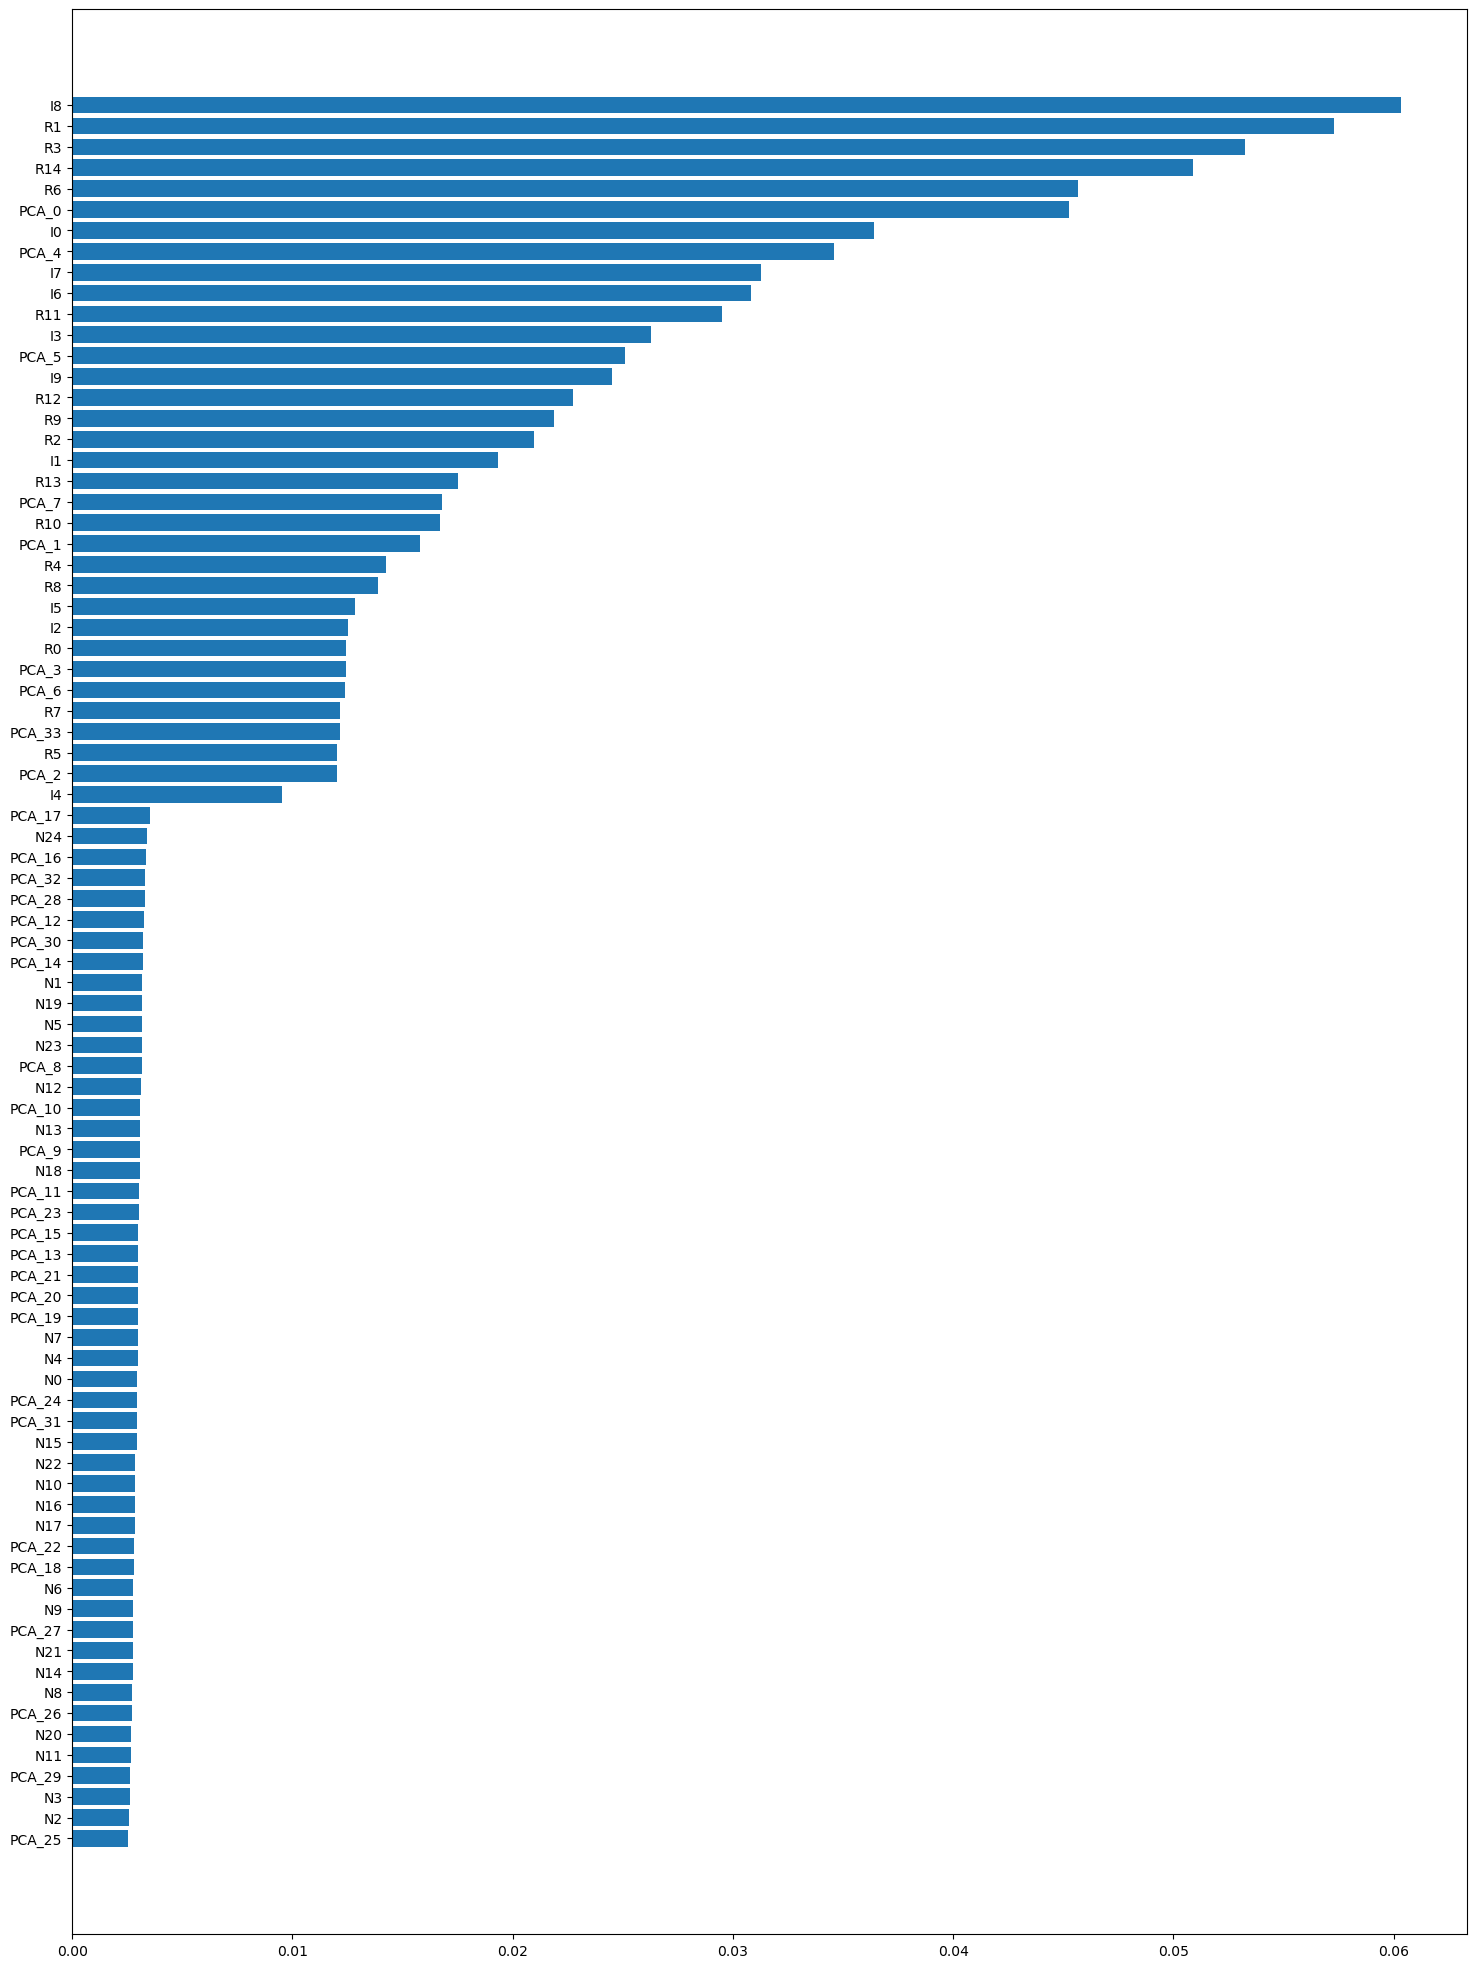

In [36]:
rf = RandomForestClassifier(random_state=1711)
rf_features, rf_mdi = run_mdi(X_pca_combine, y, rf)
fig, ax = plt.subplots(figsize=(18, 25))
ax.barh(rf_features, rf_mdi)

Run MDA using RF

Baseline Accurarcy = 0.9251
Traing with shuffling feature I0, with accuracy=0.9250 and difference=0.0001
Traing with shuffling feature I1, with accuracy=0.9232 and difference=0.0019
Traing with shuffling feature I2, with accuracy=0.9229 and difference=0.0022
Traing with shuffling feature I3, with accuracy=0.9220 and difference=0.0031
Traing with shuffling feature I4, with accuracy=0.9244 and difference=0.0007
Traing with shuffling feature I5, with accuracy=0.9223 and difference=0.0028
Traing with shuffling feature I6, with accuracy=0.9219 and difference=0.0032
Traing with shuffling feature I7, with accuracy=0.9214 and difference=0.0037
Traing with shuffling feature I8, with accuracy=0.9272 and difference=-0.0021
Traing with shuffling feature I9, with accuracy=0.9243 and difference=0.0008
Traing with shuffling feature R0, with accuracy=0.9239 and difference=0.0012
Traing with shuffling feature R1, with accuracy=0.9236 and difference=0.0015
Traing with shuffling feature R2, with accuracy

<BarContainer object of 84 artists>

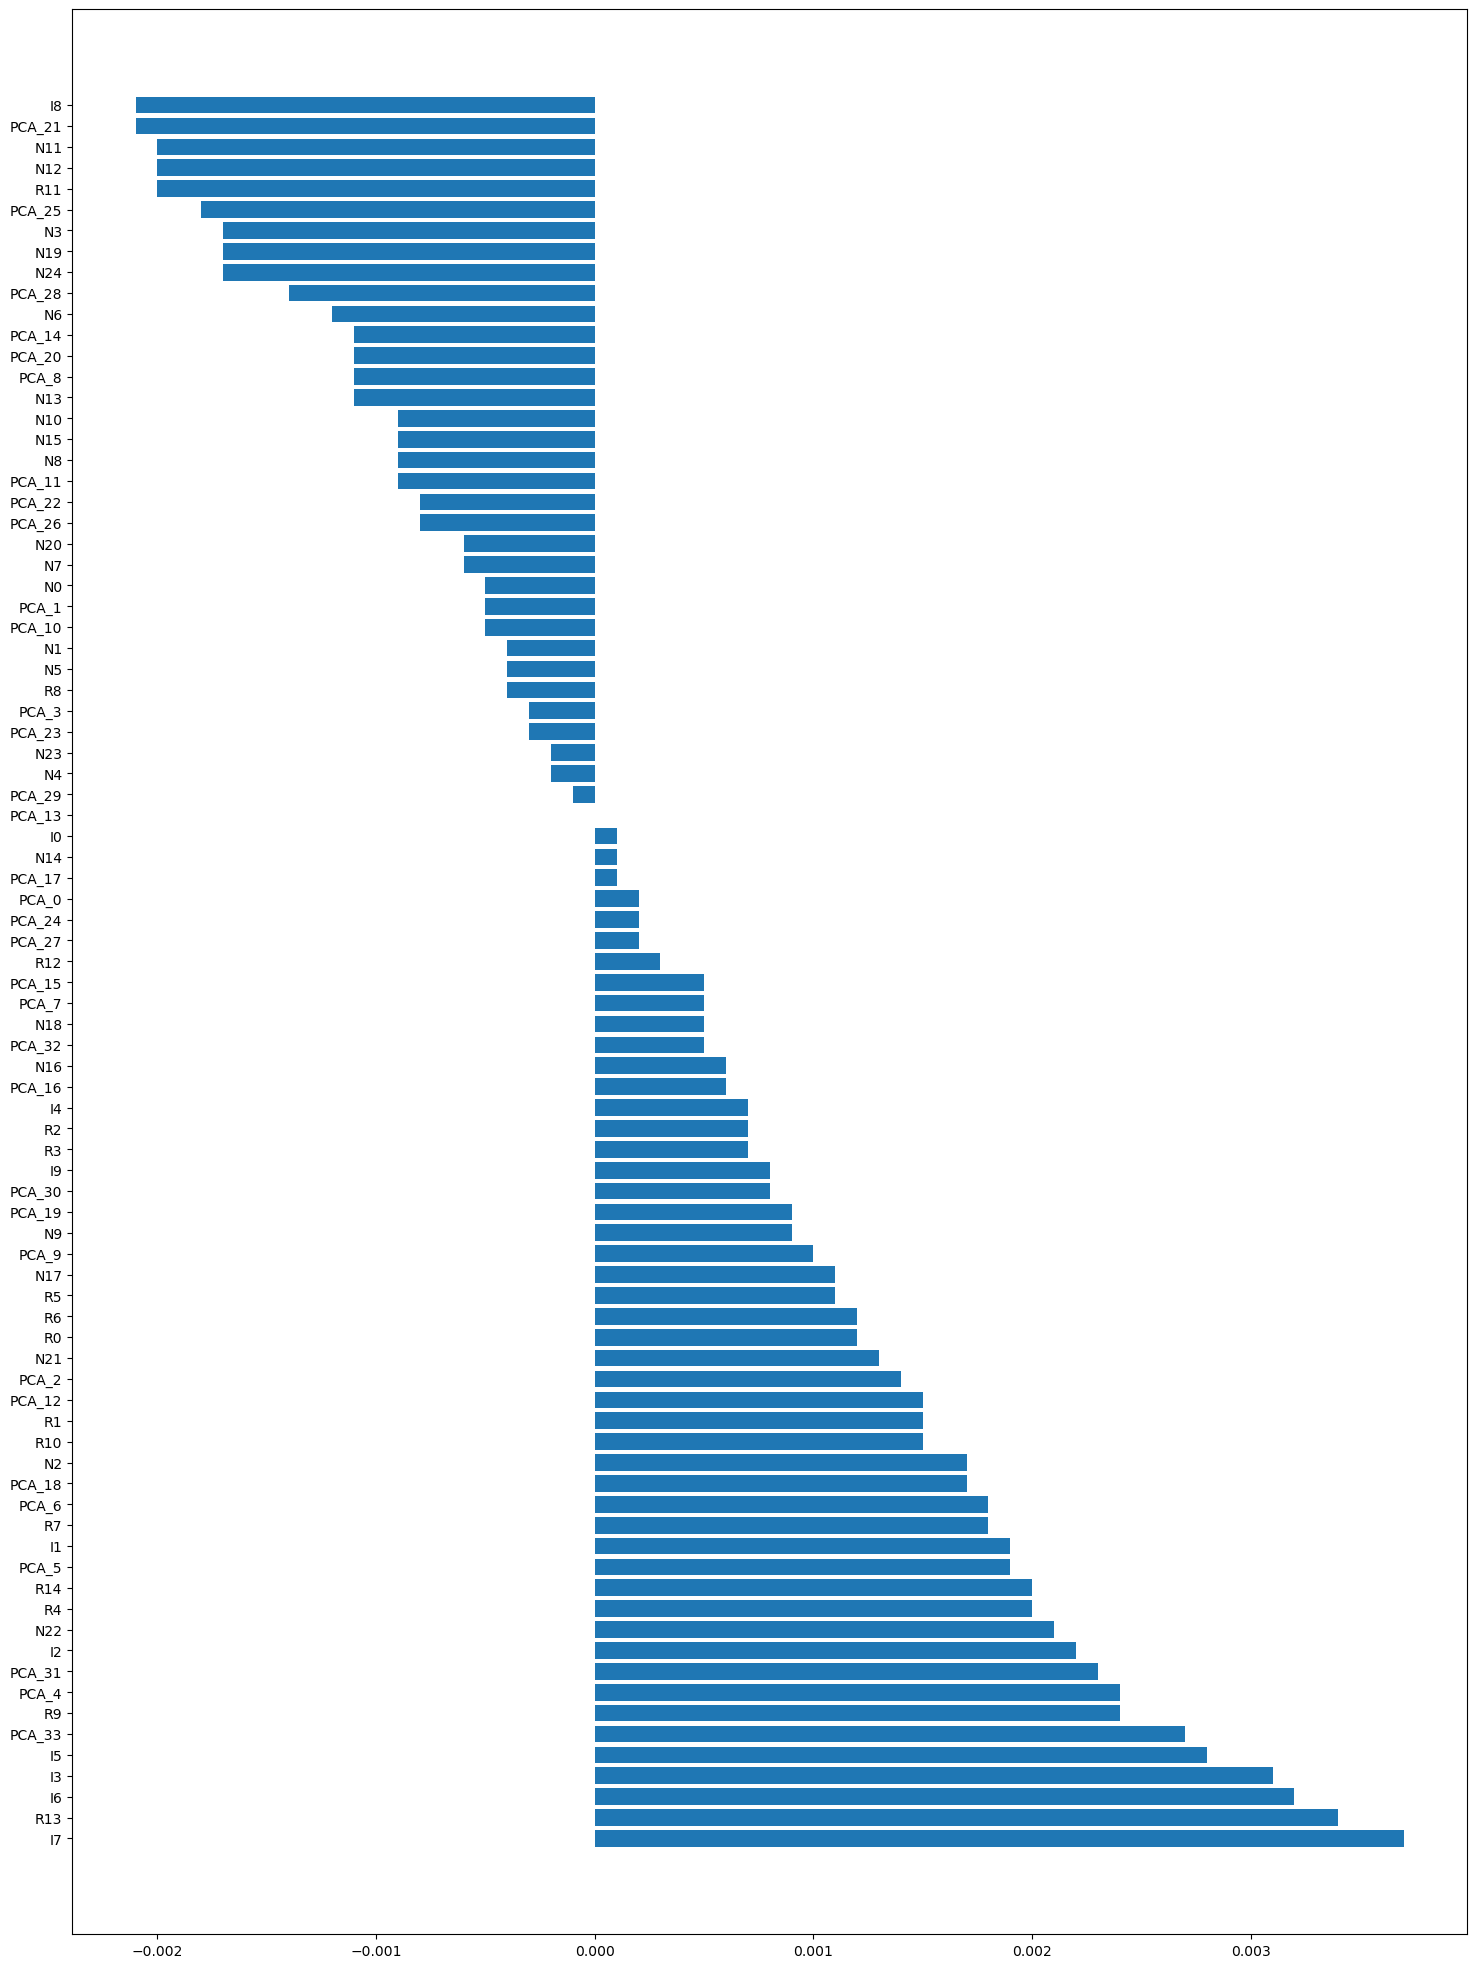

In [37]:
rf = RandomForestClassifier(random_state=1711)
mda_features, mda_scores = run_mda(X_pca_combine, y, rf)
fig, ax = plt.subplots(figsize=(18, 25))
ax.barh(mda_features, mda_scores)

Run SFI using RF

Baseline Accurarcy = 0.9251
Traing RF on the single feature I0, with accuracy=0.5523 and difference=0.3728
Traing RF on the single feature I1, with accuracy=0.5550 and difference=0.3701
Traing RF on the single feature I2, with accuracy=0.4978 and difference=0.4273
Traing RF on the single feature I3, with accuracy=0.5373 and difference=0.3878
Traing RF on the single feature I4, with accuracy=0.4926 and difference=0.4325
Traing RF on the single feature I5, with accuracy=0.4952 and difference=0.4299
Traing RF on the single feature I6, with accuracy=0.5431 and difference=0.3820
Traing RF on the single feature I7, with accuracy=0.5298 and difference=0.3953
Traing RF on the single feature I8, with accuracy=0.6180 and difference=0.3071
Traing RF on the single feature I9, with accuracy=0.5373 and difference=0.3878
Traing RF on the single feature R0, with accuracy=0.4997 and difference=0.4254
Traing RF on the single feature R1, with accuracy=0.5856 and difference=0.3395
Traing RF on the single 

<BarContainer object of 84 artists>

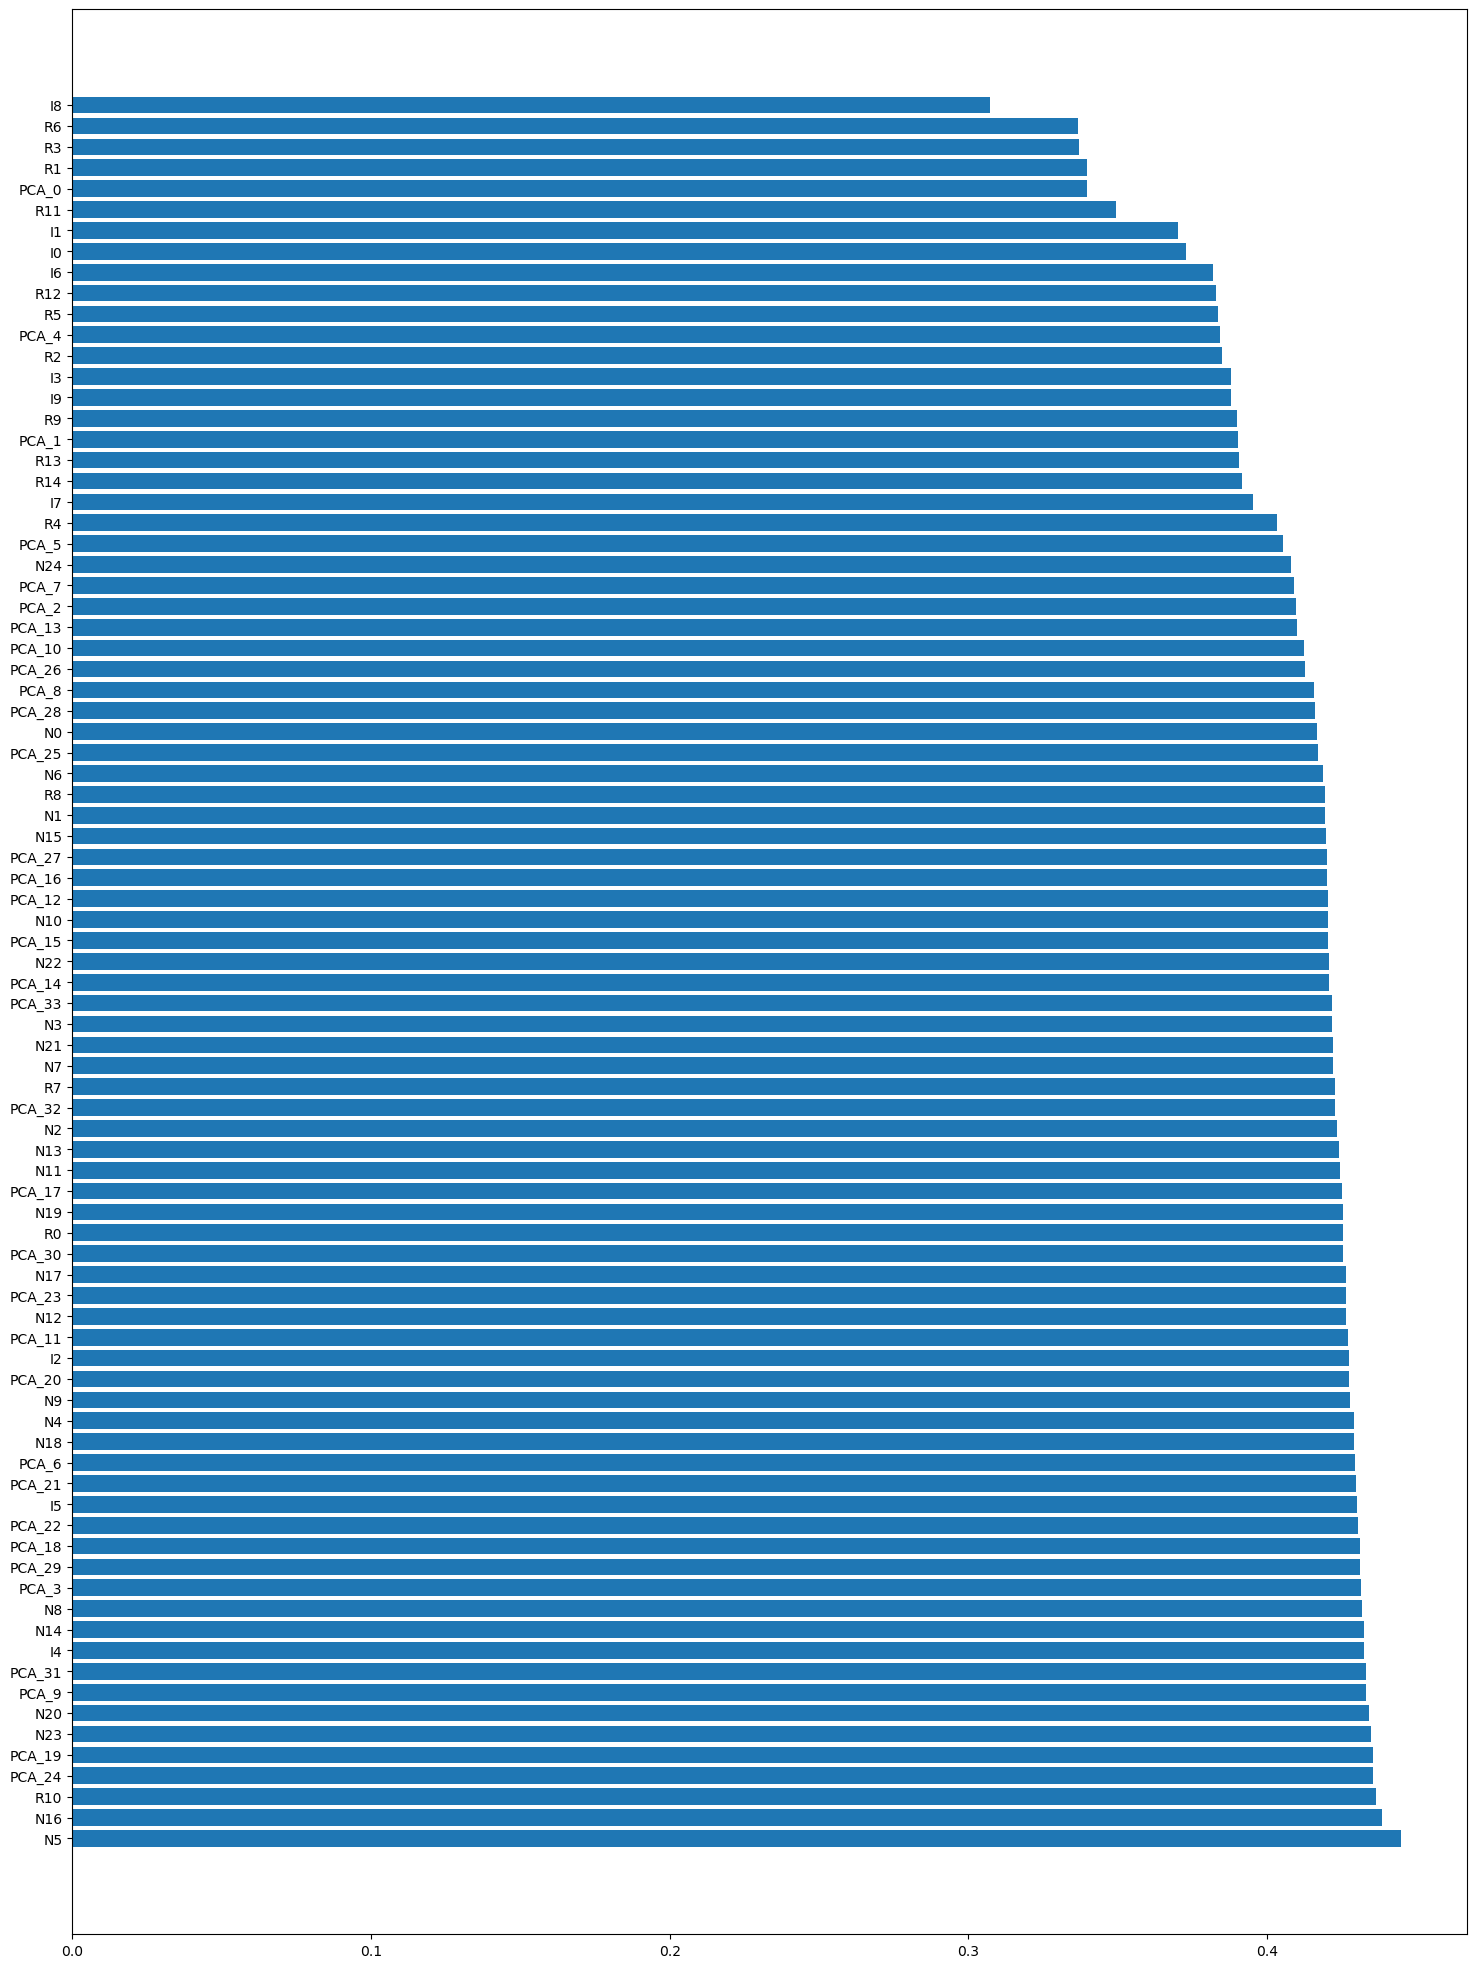

In [41]:
rf = RandomForestClassifier(random_state=1711)
sfi_features, sfi_scores = run_sfi(X_pca_combine, y, rf)
fig, ax = plt.subplots(figsize=(18, 25))
ax.barh(sfi_features, sfi_scores)